<a href="https://colab.research.google.com/github/AP2324/trabajo-equipo-9/blob/main/01_data_scientist_submit_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar la biblioteca Syft para realizar operaciones seguras en datos privados
import syft as sy

# Importar la biblioteca JAX para cálculos numéricos de alto rendimiento
import jax

# Importar la biblioteca Matplotlib para trazar gráficos
import matplotlib.pyplot as plt

# Importar la biblioteca NumPy para manipulación de matrices y cálculos numéricos
import numpy as np
import itertools

## 1. Acceso e Inspección de Datos por el Data Scientist (DS)


En esta parte del tutorial, nos enfocaremos en el rol del Data Scientist (DS), quien necesita acceder al dominio donde el Data Owner (DO) ha subido los datos, inspeccionar los conjuntos de datos disponibles y trabajar con datos ficticios para el desarrollo de modelos.

### El DS inicia sesión en el dominio utilizando las credenciales proporcionadas por el DO.

In [ ]:
# 'mnist-domain' es el nombre del dominio donde se han subido los datos.
node = sy.orchestra.launch(name="mnist-domain", dev_mode=True)
ds_client = node.login(email="sheldon17@caltech.edu", password="changethis")

Staging Protocol Changes...
Data Migrated to latest version !!!
Logged into <mnist-domain: High side Domain> as <sheldon17@caltech.edu>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

###  Una vez logueado, el DS inspecciona los conjuntos de datos disponibles en el dominio.


In [ ]:
datasets = ds_client.datasets.get_all()
assert len(datasets) == 1  # Se espera encontrar un conjunto de datos, el subido por el DO.

In [ ]:
# El DS ahora puede ver los activos dentro del conjunto de datos, que deberían incluir las imágenes y las etiquetas de entrenamiento.
assets = datasets[0].assets
assert len(assets) == 2  # Se esperan dos activos: uno para imágenes y otro para etiquetas.
assets

DictTuple(syft.service.dataset.dataset.Asset, syft.service.dataset.dataset.Asset)

In [ ]:
training_images = assets[0]  # Acceso al activo de imágenes de entrenamiento.
training_images

syft.service.dataset.dataset.Asset

In [ ]:
training_labels = assets[1]  # Acceso al activo de etiquetas de entrenamiento.
training_labels

syft.service.dataset.dataset.Asset

#### El DS verifica que no puede acceder a los datos reales, solo a los datos ficticios.

In [ ]:
assert training_images.data == None # Asegura que los datos reales no sean accesibles.

#### El DS trabaja con los datos ficticios para el desarrollo y prueba de modelos.

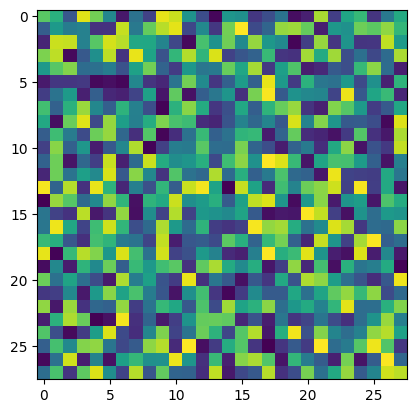

In [ ]:

mock_images = training_images.mock  # Acceso a las imágenes ficticias.
plt.imshow(np.reshape(mock_images[0], (28, 28)))  # Visualización de una imagen ficticia.

####  Para construir una función en PySyft, el DS necesita punteros a los datos ficticios.


En PySyft, un puntero es un objeto que actúa como una referencia a datos que están almacenados en otro lugar, como en otro nodo o máquina en una red de aprendizaje federado. En lugar de tener acceso directo a los datos, lo que podría comprometer la privacidad, trabajas con estos punteros que te permiten realizar operaciones sobre los datos sin necesidad de acceder a ellos directamente.

In [ ]:
mock_images_ptr = training_images.pointer  # Puntero a las imágenes ficticias
mock_images_ptr

```python
TwinPointer(Mock)
```
array([[0.74326611, 0.63237108, 0.27224168, ..., 0.45205951, 0.92774203,
        0.89601457],
       [0.54708683, 0.56632694, 0.16792098, ..., 0.36633723, 0.25076943,
        0.94116954],
       [0.09165152, 0.68159009, 0.88856844, ..., 0.49494068, 0.54632511,
        0.55523037],
       ...,
       [0.60845032, 0.18091886, 0.94879059, ..., 0.50738997, 0.66355957,
        0.16425232],
       [0.4984032 , 0.87090367, 0.75100362, ..., 0.16405165, 0.41709031,
        0.08417808],
       [0.29932972, 0.01874042, 0.11020068, ..., 0.73627514, 0.32106006,
        0.78578294]])

In [ ]:
type(mock_images_ptr)

syft.service.action.numpy.NumpyArrayObject

In [ ]:
mock_labels = training_labels.mock
mock_labels = training_labels.mock  # Acceso a las etiquetas ficticias.
mock_labels_ptr = training_labels.pointer  # Puntero a las etiquetas ficticias.
mock_labels_ptr

```python
TwinPointer(Mock)
```
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Cuando el DS accede a los datos ficticios (mock_images y mock_labels) para el desarrollo y prueba de modelos, en realidad está trabajando con datos que simulan la estructura y el tipo de los datos reales pero sin contener información sensible. Al obtener punteros a estos datos ficticios (mock_images_ptr y mock_labels_ptr), el DS puede desarrollar funciones y algoritmos que están diseñados para operar sobre los datos como si fueran los reales, preparándose para cuando necesite solicitar la ejecución de estas operaciones en el conjunto de datos real por parte del DO.
Con esto hemos cubierto cómo el DS accede de forma segura a los datos y comienza a trabajar en el desarrollo del modelo utilizando datos ficticios.

## 2. Preparación del Código de Entrenamiento y Experimentación por el DS

El DS desarrolla una función de entrenamiento para un modelo de red neuronal utilizando la biblioteca JAX, que permite un cálculo numérico eficiente y diferenciación automática. Esta función se diseñó para trabajar con los datos ficticios, permitiendo al DS ajustar y validar el enfoque de entrenamiento sin exponer los datos sensibles.

In [ ]:
# Definición de la función de entrenamiento del modelo
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # Importación de los paquetes necesarios para la construcción y entrenamiento del modelo
    import jax #jax es una biblioteca diseñada para cálculos numéricos de alta velocidad
    from jax.example_libraries import stax #submódulo para construir y entrenar la red neuronal
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp # Importar el módulo numpy compatible con JAX
    import numpy.random as npr
    from jax import jit, grad, random

    # Definición de la arquitectura de la red neuronal utilizando capas densas y funciones de activación
    #stax.serial toma como argumentos las capas que compondrán la red, y las "apila" en el orden en que se proporcionan, de modo que la salida de una capa se convierte en la entrada de la siguiente.
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,     # Capa densa o completamente conectada con 1024 neuronas
        Dense(1024), Relu,     # Relu es una funcion no lineal definida como f(x) = max(0, x)
       #La función de activación LogSoftmax se aplica a la salida de la última capa densa. Convierte los logits en probabilidades logarítmicas
        Dense(10), LogSoftmax) # capa densa, pero con 10 unidades, correspondientes a las 10 clases posibles de los dígitos MNIST (0 a 9)

    # Inicialización de los parámetros del modelo de forma aleatoria
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784)) # Inicia de manera aleatoria los parametros de la red antes de empezar el entrenamiento

    # Número de pasadas completas sobre el conjunto de datos durante el entrenamiento.
    num_epochs = 10

    # Número de muestras por lote para actualizar los parámetros del modelo.
    batch_size = 4

    # Número total de imágenes en el conjunto de datos de entrenamiento.
    num_train = mnist_images.shape[0]

    # Cálculo del número de lotes completos y si hay un lote "incompleto" al final.
    num_complete_batches, leftover = divmod(num_train, batch_size)

    # El número total de lotes es el número de lotes completos más uno si hay un lote "incompleto".
    num_batches = num_complete_batches + bool(leftover)

    # Tamaño del paso para la actualización de los parámetros en el optimizador.
    step_size = 0.001

    # Parámetro 'mass' del optimizador de momentum que ayuda a suavizar las actualizaciones de los parámetros.
    momentum_mass = 0.9


    # Establecimiento de hiperparámetros como número de épocas, tamaño del lote, etc.
    num_epochs = 10 # Número de muestras por lote para actualizar los parámetros del modelo.
    batch_size = 4  # Número total de imágenes en el conjunto de datos de entrenamiento..
    num_train = mnist_images.shape[0]  # Número total de imágenes en el conjunto de datos de entrenamiento.
    num_complete_batches, leftover = divmod(num_train, batch_size) # Cálculo del número de lotes completos y si hay un lote "incompleto" al final.
    num_batches = num_complete_batches + bool(leftover) # El número total de lotes es el número de lotes completos más uno si hay un lote "incompleto".
    step_size = 0.001 # Tamaño del paso para la actualización de los parámetros en el optimizador.
    momentum_mass = 0.9 # Parámetro 'mass' del optimizador de momentum que ayuda a suavizar las actualizaciones de los parámetros.

    # Inicialización del optimizador, en este caso, utilizando momentum
    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
    opt_state = opt_init(init_params)

    # Definición de la función de actualización del modelo para una iteración de entrenamiento
    @jit #Este decorador de JAX compila la función para mejorar su rendimiento mediante la compilación Just-In-Time
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch), opt_state)

    # Función para generar lotes de datos de forma aleatoria
    def data_stream():
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield mnist_images[batch_idx], mnist_labels[batch_idx]

    # Definición de la función de pérdida
    def loss(params, batch):
        inputs, targets = batch
        preds = predict(params, inputs)
        return -jnp.mean(jnp.sum(preds * targets, axis=1))

    # Función para calcular la precisión del modelo
    def accuracy(params, batch):
        inputs, targets = batch
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(predict(params, inputs), axis=1)
        return jnp.mean(predicted_class == target_class)

    # Proceso de entrenamiento, iterando sobre el número de épocas y actualizando el modelo en cada iteración
    batches = data_stream()
    train_accs = []
    print("\nStarting training...")

    # Defino 'itercount'
    itercount = itertools.count(start=0)

    for epoch in range(num_epochs):
        start_time = time.time()
        for _ in range(num_batches):
           # 'next(itercount)' proporciona un contador único para cada actualización
            opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time
    params = get_params(opt_state)
    train_acc = accuracy(params, (mnist_images, mnist_labels))
    print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
    print(f"Training set accuracy {train_acc}")
    train_accs.append(train_acc)

    # Retornar las precisiónes de entrenamiento y los parámetros del modelo después del entrenamiento
    return train_accs, params

In [ ]:
train_accs, params = mnist_3_linear_layers(mnist_images=mock_images, mnist_labels=mock_labels)


Starting training...
Epoch 9 in 4.37 sec
Training set accuracy 0.9250000715255737


#### Inspect the training accuracies and the shape of the model's parameters

In [ ]:
train_accs

[Array(0.9250001, dtype=float32)]

In [ ]:
jax.tree_map(lambda x: x.shape, params)

[((784, 1024), (1024,)),
 (),
 ((1024, 1024), (1024,)),
 (),
 ((1024, 10), (10,)),
 ()]

## 3.  Ahora que el código funciona con datos ficticios, el DS envía la solicitud de ejecución del código al DO

#### Primero, el DS envuelve la función de entrenamiento con el patron decorador @sy.syft_function.






In [ ]:
@sy.syft_function(input_policy=sy.ExactMatch(mnist_images=mock_images_ptr, mnist_labels=mock_labels_ptr),
                  output_policy=sy.SingleExecutionExactOutput())
# Definición de la función de entrenamiento del modelo
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # Importación de los paquetes necesarios para la construcción y entrenamiento del modelo
    import jax #jax es una biblioteca diseñada para cálculos numéricos de alta velocidad
    from jax.example_libraries import stax #submódulo para construir y entrenar la red neuronal
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp # Importar el módulo numpy compatible con JAX
    import numpy.random as npr
    from jax import jit, grad, random

    # Definición de la arquitectura de la red neuronal utilizando capas densas y funciones de activación
    #stax.serial toma como argumentos las capas que compondrán la red, y las "apila" en el orden en que se proporcionan, de modo que la salida de una capa se convierte en la entrada de la siguiente.
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,     # Capa densa o completamente conectada con 1024 neuronas
        Dense(1024), Relu,     # Relu es una funcion no lineal definida como f(x) = max(0, x)
       #La función de activación LogSoftmax se aplica a la salida de la última capa densa. Convierte los logits en probabilidades logarítmicas
        Dense(10), LogSoftmax) # capa densa, pero con 10 unidades, correspondientes a las 10 clases posibles de los dígitos MNIST (0 a 9)

    # Inicialización de los parámetros del modelo de forma aleatoria
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784)) # Inicia de manera aleatoria los parametros de la red antes de empezar el entrenamiento

    # Número de pasadas completas sobre el conjunto de datos durante el entrenamiento.
    num_epochs = 10

    # Número de muestras por lote para actualizar los parámetros del modelo.
    batch_size = 4

    # Número total de imágenes en el conjunto de datos de entrenamiento.
    num_train = mnist_images.shape[0]

    # Cálculo del número de lotes completos y si hay un lote "incompleto" al final.
    num_complete_batches, leftover = divmod(num_train, batch_size)

    # El número total de lotes es el número de lotes completos más uno si hay un lote "incompleto".
    num_batches = num_complete_batches + bool(leftover)

    # Tamaño del paso para la actualización de los parámetros en el optimizador.
    step_size = 0.001

    # Parámetro 'mass' del optimizador de momentum que ayuda a suavizar las actualizaciones de los parámetros.
    momentum_mass = 0.9


    # Establecimiento de hiperparámetros como número de épocas, tamaño del lote, etc.
    num_epochs = 10 # Número de muestras por lote para actualizar los parámetros del modelo.
    batch_size = 4  # Número total de imágenes en el conjunto de datos de entrenamiento..
    num_train = mnist_images.shape[0]  # Número total de imágenes en el conjunto de datos de entrenamiento.
    num_complete_batches, leftover = divmod(num_train, batch_size) # Cálculo del número de lotes completos y si hay un lote "incompleto" al final.
    num_batches = num_complete_batches + bool(leftover) # El número total de lotes es el número de lotes completos más uno si hay un lote "incompleto".
    step_size = 0.001 # Tamaño del paso para la actualización de los parámetros en el optimizador.
    momentum_mass = 0.9 # Parámetro 'mass' del optimizador de momentum que ayuda a suavizar las actualizaciones de los parámetros.

    # Inicialización del optimizador, en este caso, utilizando momentum
    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
    opt_state = opt_init(init_params)

    # Definición de la función de actualización del modelo para una iteración de entrenamiento
    @jit #Este decorador de JAX compila la función para mejorar su rendimiento mediante la compilación Just-In-Time
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch), opt_state)

    # Función para generar lotes de datos de forma aleatoria
    def data_stream():
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield mnist_images[batch_idx], mnist_labels[batch_idx]

    # Definición de la función de pérdida
    def loss(params, batch):
        inputs, targets = batch
        preds = predict(params, inputs)
        return -jnp.mean(jnp.sum(preds * targets, axis=1))

    # Función para calcular la precisión del modelo
    def accuracy(params, batch):
        inputs, targets = batch
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(predict(params, inputs), axis=1)
        return jnp.mean(predicted_class == target_class)

    # Proceso de entrenamiento, iterando sobre el número de épocas y actualizando el modelo en cada iteración
    batches = data_stream()
    train_accs = []
    print("\nStarting training...")

    # Defino 'itercount'
    itercount = itertools.count(start=0)

    for epoch in range(num_epochs):
        start_time = time.time()
        for _ in range(num_batches):
           # 'next(itercount)' proporciona un contador único para cada actualización
            opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time
    params = get_params(opt_state)
    train_acc = accuracy(params, (mnist_images, mnist_labels))
    print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
    print(f"Training set accuracy {train_acc}")
    train_accs.append(train_acc)

    # Retornar las precisiónes de entrenamiento y los parámetros del modelo después del entrenamiento
    return train_accs, params


SyftSuccess: Syft function 'mnist_3_linear_layers' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

#### Luego, el DS crea un nuevo proyecto con un nombre y descripción relevantes, así como se especifica a sí mismo como miembro del proyecto.

In [ ]:
new_project = sy.Project(
    name="Training a 3-layer jax neural network on MNIST data",
    description="""Hola, me gustaría entrenar mi red neuronal en tus datos MNIST
                (También podría descargarlos en línea, pero solo quiero usar Syft porque es genial)""",
    members=[ds_client],
)
new_project

syft.service.project.project.ProjectSubmit

#### Añadir una solicitud de código al proyecto.

In [ ]:
#create_code_request: Agrega una solicitud de ejecución de código al proyecto. Esto incluye la función de entrenamiento mnist_3_linear_layers y especifica qué cliente (DS) está haciendo la solicitud.
new_project.create_code_request(obj=mnist_3_linear_layers, client=ds_client)

SyftSuccess: Code request for 'mnist_3_linear_layers' successfully added to 'Training a 3-layer jax neural network on MNIST data' Project. To see code requests by a client, run `[your_client].code`

In [ ]:
ds_client.code

#### Inicia el proyecto lo cual notificará al DO.

In [ ]:
project = new_project.start()

In [ ]:
project.events  # Esto permite al DS ver los eventos relacionados con el proyecto, como la aprobación o rechazo de solicitudes.



[syft.service.project.project.ProjectRequest]

In [ ]:
project.requests  # Muestra todas las solicitudes de código asociadas con el proyecto.


[syft.service.request.request.Request]

In [ ]:
project.requests[0]  # Accede a la primera solicitud de código, que en este caso es la única solicitud hecha por el DS.

syft.service.request.request.Request

### 📓 Now switch to the [second DO's notebook](./02-data-owner-review-approve-code.ipynb)